# Predicción de aprobación de préstamo para compra de vivienda

Desafío Spike Septiembre 2020 - Predicción de desviación de precios en el sistema eléctrico chileno

Más información del desafío $\href{https://github.com/SpikeLab-CL/desafio_spike_energia_public}{Desafío\:Spike}$.

#### Imports

In [1]:
# imports

# interns
import datetime
import gc

# extern
import numpy as np
import pandas as pd
import tqdm

from sklearn.preprocessing import OrdinalEncoder, RobustScaler
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns

# custom
from eda import *
from classifier import  *
from utils import *

RANDOM_STATE = 123

## Parte 1 - Costos marginales



In [57]:
# Costo marginal real
cmr_df = pd.read_csv("costo_marginal_real.csv")
print(f"costo marginal real conformado por {cmr_df.shape[0]} filas y {cmr_df.shape[1]} columnas")

# Costo marginal programado
cmp_df = pd.read_csv("costo_marginal_programado.csv")
print(f"costo marginal programado conformado por {cmp_df.shape[0]} filas y {cmp_df.shape[1]} columnas")

costo marginal real conformado por 4309951 filas y 7 columnas
costo marginal programado conformado por 1192124 filas y 5 columnas


### Costos marginales reales - Primeras 5 filas

In [3]:
cmr_df.head(5)

,barra_mnemotecnico,barra_referencia_mnemotecnico,fecha,hora,costo_en_dolares,costo_en_pesos,nombre
0,BA01T005SE075T005,BA02T002SE032T002,2019-04-06,25,62.24,41.47176,BA S/E LORETO 15KV
1,BA01T005SE175T005,BA02T002SE032T002,2019-04-06,25,62.56,41.68498,BA S/E RETIRO 13.2KV
2,BA03R002SE002R002,BA02T002SE032T002,2019-04-06,25,60.04,40.00585,BA S/E ALTAMIRANO 12.5KV BP1
3,BA01R002SE012R002,BA02T002SE032T002,2019-04-06,25,61.65,41.07863,BA S/E CURACAVI 44KV B1
4,BA03R002SE013R002,BA02T002SE032T002,2019-04-06,25,59.55,39.67936,BA S/E EL MANZANO (ENEL DISTRIBUCIÓN) 23KV BP1


### Costos marginales reales - Primeras 5 filas

In [4]:
cmp_df.head(5)

,mnemotecnico_barra,nombre_barra,fecha,hora,costo
0,BA01T002SE002T002,BA S/E ALTO JAHUEL 110KV SECCION 1,2019-01-01,1,49.897334
1,BA01T002SE002T002,BA S/E ALTO JAHUEL 110KV SECCION 1,2019-01-01,2,50.471616
2,BA01T002SE002T002,BA S/E ALTO JAHUEL 110KV SECCION 1,2019-01-01,3,50.077821
3,BA01T002SE002T002,BA S/E ALTO JAHUEL 110KV SECCION 1,2019-01-01,4,49.796216
4,BA01T002SE002T002,BA S/E ALTO JAHUEL 110KV SECCION 1,2019-01-01,5,49.796216


### Valores duplicados - Verificación

In [5]:
print(f"hay {cmr_df.shape[0] - cmr_df.drop_duplicates().shape[0]} filas duplicadas en los costos marginales reales")
print(f"hay {cmp_df.shape[0] - cmp_df.drop_duplicates().shape[0]} filas duplicadas en los costos marginales programados")

hay 0 filas duplicadas en los costos marginales reales
hay 4283 filas duplicadas en los costos marginales programados


### Valores duplicados - Eliminar

Se eliminan las filas duplicadas porque no aportan datos adicionales

In [58]:
# suprimimos las filas duplicadas en los costos programados
cmp_df = cmp_df.drop_duplicates()

### Valores duplicados - misma barra-fecha-hora con distintos costos

Se verifica si hay más de un costo marginal programado para la misma barra a la misma fecha y hora del día

In [7]:
print(f"hay {cmr_df.drop(['costo_en_dolares', 'costo_en_pesos'], axis=1).shape[0] - cmr_df.drop(['costo_en_dolares', 'costo_en_pesos'], axis=1).drop_duplicates().shape[0]} barras con más de un costo real por fecha y hora")
print(f"hay {cmp_df.drop(['costo'], axis=1).shape[0] - cmp_df.drop(['costo'], axis=1).drop_duplicates().shape[0]} barras con más de un costo programado por fecha y hora")

hay 0 barras con más de un costo real por fecha y hora
hay 183946 barras con más de un costo programado por fecha y hora


### Valores duplicados - Conversar el último

Basado en una regla simple, nos quedamos con el último costo programado cuando hay más de uno para la misma barra, fecha, y hora

In [59]:
# index de las filas a conservar
idx = cmp_df["costo"].drop_duplicates(keep="last").index
cmp_df = cmp_df[cmp_df.index.isin(idx)]
cmp_df.shape

(944243, 5)

### barras no identificadas $\rightarrow$ nombre mnemotecnico '-'

In [9]:
print(f"Hay {cmr_df[cmr_df['barra_mnemotecnico']=='-'].shape[0]} barras no identificadas en los costos marginales reales")
print(f"Hay {cmp_df[cmp_df['mnemotecnico_barra']=='-'].shape[0]} barras no identificadas en los costos marginales programados")

Hay 0 barras no identificadas en los costos marginales reales
Hay 147852 barras no identificadas en los costos marginales programados


Hay barras no idenficadas. Dado que no podemos saber si los datos corresponden a una sola barra o varias, ni podemos saber cúal fila correspondería a cúal barra, borramos dichas filas

In [60]:
# suprimimos filas sin barra identificada
cmp_df = cmp_df[cmp_df['mnemotecnico_barra']!='-']
cmp_df.shape

(796391, 5)

### Número total de barras en la base

Calculando el número total de barras paras que hay dados de los costos reales, de los costos programados, y el porcentaje de barras en la base para las que hay registros de costos programados y costos reales.

In [61]:
# barras en costo_marginal_real
barras_real = set(cmr_df["barra_mnemotecnico"].unique())

# barras en costo marginal programado
barras_prog = set(cmp_df["mnemotecnico_barra"].unique())

# barras en la base

barras = barras_real.union(barras_prog)

print(f"Número total de barras en la base: {len(barras)}")
print(f"Número de barras programadas: {len(barras_prog)}")
print(f"Porcentaje de barras en la base que tienen un costo programado: {100 * round(len(barras_prog) / len(barras), 2)} %")
                

Número total de barras en la base: 1038
Número de barras programadas: 232
Porcentaje de barras en la base que tienen un costo programado: 22.0 %


## Barras de referencia

Solo hay una barra de referencia

In [62]:
# única barra de referencia
cmr_df["barra_referencia_mnemotecnico"].unique()

array(['BA02T002SE032T002'], dtype=object)

### Merging

Combinando los dos datasets en uno solo, la tabla de costos marginales

El merge se hace a partir del nombre mnemotecnico de la barra, la fecha, y la hora del día. Se asume que la columna 'costo' de los costos marginales programados se encuentra en dólares. El merge es 'outer' para mantener todas las barras de ambos datasets.

Así, si barras que solo registran costos marginales, el costo programado sera NaN, y viceversa.

In [63]:
%%time
cm_df = pd.merge(cmr_df[["barra_mnemotecnico", "fecha", "hora", "costo_en_dolares","costo_en_pesos"]],
             cmp_df[["mnemotecnico_barra","fecha", "hora", "costo"]], how="outer",
                           left_on = ['barra_mnemotecnico', 'fecha', 'hora' ], 
                           right_on = ['mnemotecnico_barra', 'fecha', 'hora'], suffixes=('', ''), sort=True)

cm_df = cm_df.drop("mnemotecnico_barra", axis=1).reset_index(drop=True)
cm_df.columns = ["barra", "fecha", "hora", "cmg_real","cmg_real_pesos", "cmg_prog"]
cm_df.to_csv("costo_marginal.csv", index=None)
cm_df

Wall time: 24.7 s


,barra,fecha,hora,cmg_real,cmg_real_pesos,cmg_prog
0,BA01G004SE001T011,2019-01-01,1,50.41,35.06973,50.116286
1,BA01G004SE001T011,2019-01-01,2,50.41,35.06973,50.522836
2,BA01G004SE001T011,2019-01-01,3,49.40,34.36709,50.119505
3,BA01G004SE001T011,2019-01-01,4,48.56,33.78271,NaN
4,BA01G004SE001T011,2019-01-01,5,46.51,32.35654,49.854087
...,...,...,...,...,...,...
4396799,BA99L117SE054L117,2019-06-30,20,47.79,32.49051,46.800602
4396800,BA99L117SE054L117,2019-06-30,21,47.79,32.49051,48.607941
4396801,BA99L117SE054L117,2019-06-30,22,47.79,32.49051,48.537587
4396802,BA99L117SE054L117,2019-06-30,23,47.79,32.49051,47.783023


### Valores nulos por columna

Porcentaje de valores nulos por columna

In [19]:
missing_values_table(cm_df)

Hay 6 columnas.
Hay 4 columns with missing values


,Missing Values,% of Total Values
cmg_prog,3600413,81.9
barra,77497,1.8
cmg_real,77497,1.8
cmg_real_pesos,77497,1.8


### Histograma de los costos marginales


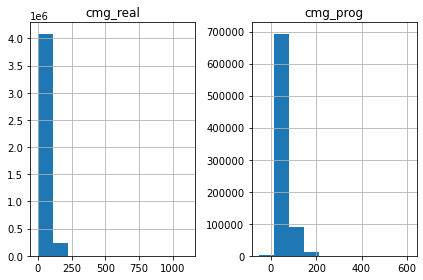

In [24]:
cm_df[["cmg_real", "cmg_prog"]].hist()
plt.tight_layout()
plt.show()

Los costos marginales programados tienden a ser más bajos que los costos marginales reales. 
Las distribuciones tienen una cola a la derecha, o 'skew positivo'. Esto quiere decir que el 50 % de los datos (la mediana) es inferior al promedio de datos. Por lo tanto, puede ser que los datos contengan outliers.

### Distribución horas

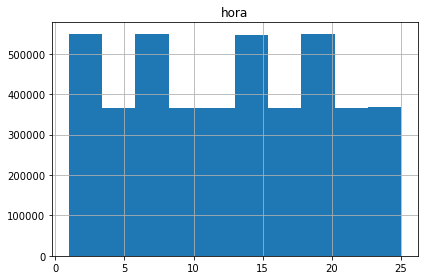

In [29]:
cm_df[["hora"]].hist()
plt.tight_layout()
plt.show()

La primera hora es identificada por un 1. Por alguna razón hay medidas para la hora 25. Esto puede representar un error, y que la hora 25 sea la primera hora del día siguiente. Queda por confirmar con la fuente de los datos.

Respecto a la distribución. Hay mpas registros para ciertas horas. Esto podría ser a que ciertas barras fueron monitoreadas más frecuentemente en términos de días/horas que otras. Dichas barras pueden ser más accesibles o más importantes, y por ende, son más frecuentadas.

### Distribución con respecto al promedio

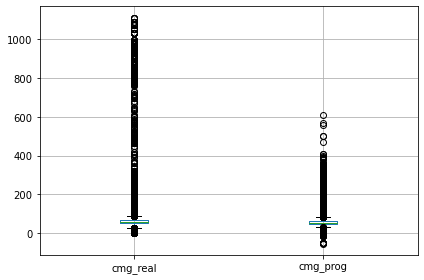

In [31]:
cm_df[["cmg_real", "cmg_prog"]].boxplot()
plt.tight_layout()
plt.show()

Los costos marginales reales muestran mayor variabilidad con respecto al promedio. A pesar de que ambos costos marginales tiene promedios parecidos, los costos marginales programados tienden a ser menores que los costos marginales reales.

Podría ser que el método para calcular los costos marginales programados sea un un poco optimista. Sin embargo, los costos marginales reales tienden a diverger.

## Parte 2 - Construcción de variables
+ desviación : diferencia entre los costos reales y programados
+ desviación_pct: desviación en porcentaje respecto al costo programado
+ desviacion_cat: 1 si la desviación porcentual sobrepasa el 15 %

In [64]:
# desviación
cm_df["desviacion"] = cm_df["cmg_real"] - cm_df["cmg_prog"]

# desviación porcentual
cm_df["desviacion_pct"] = 100 * cm_df["desviacion"] / cm_df["cmg_prog"]

# si la desviación sobrepasa el 15 % de desviación porcentual
cm_df["desviacion_cat"] = np.where(abs(cm_df["desviacion"]) <= 15, 0, 1)

# si la desviación porcentual es nula, entonces la variable categórica también
cm_df["desviacion_cat"].iloc[cm_df["desviacion_pct"].astype(str)=="nan"] = np.nan

cm_df

C:\Users\HP\anaconda3\envs\latam\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,barra,fecha,hora,cmg_real,cmg_real_pesos,cmg_prog,desviacion,desviacion_pct,desviacion_cat
0,BA01G004SE001T011,2019-01-01,1,50.41,35.06973,50.116286,0.293714,0.586064,0.0
1,BA01G004SE001T011,2019-01-01,2,50.41,35.06973,50.522836,-0.112836,-0.223336,0.0
2,BA01G004SE001T011,2019-01-01,3,49.40,34.36709,50.119505,-0.719505,-1.435578,0.0
3,BA01G004SE001T011,2019-01-01,4,48.56,33.78271,NaN,NaN,NaN,NaN
4,BA01G004SE001T011,2019-01-01,5,46.51,32.35654,49.854087,-3.344087,-6.707749,0.0
...,...,...,...,...,...,...,...,...,...
4396799,BA99L117SE054L117,2019-06-30,20,47.79,32.49051,46.800602,0.989398,2.114071,0.0
4396800,BA99L117SE054L117,2019-06-30,21,47.79,32.49051,48.607941,-0.817941,-1.682731,0.0
4396801,BA99L117SE054L117,2019-06-30,22,47.79,32.49051,48.537587,-0.747587,-1.540222,0.0
4396802,BA99L117SE054L117,2019-06-30,23,47.79,32.49051,47.783023,0.006977,0.014601,0.0


### Distribución estática de desviacion_cat

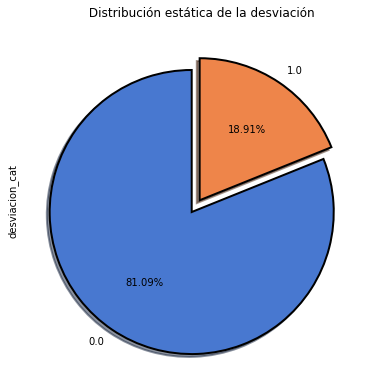

In [65]:
plot_distribution_labels(cm_df, " Distribución estática de la desviación", "desviacion_cat")

### Distribución dinámica de desviacion_cat 

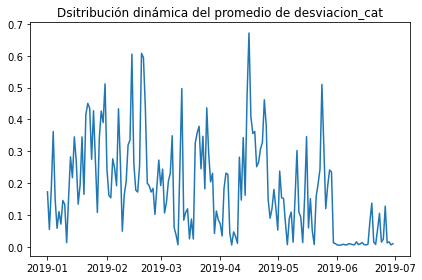

Wall time: 482 ms


In [87]:
%%time
mean_desv_cat = cm_df.groupby('fecha')[['desviacion_cat']].mean()
mean_desv_cat = mean_desv_cat.reset_index()
mean_desv_cat['fecha'] = pd.to_datetime(mean_desv_cat['fecha'])

mean_desv_cat.columns = ['fecha', 'desviacion_cat_promedio']

plt.plot(mean_desv_cat['fecha'],mean_desv_cat['desviacion_cat_promedio'])
plt.title('Dsitribución dinámica del promedio de desviacion_cat')
plt.tight_layout()
plt.show()

Podemos ver que al menos en promedio, la desviación categórica sufre mucha variación temporal. Tiene périodos de tiempo donde hay muchos peaks, que indican mal estimación de los costos marginales por parte de la programación. Otros périodos, como en junio, donde por varios días se mantuvo a 0.

## Parte 3 - Visualización de datos

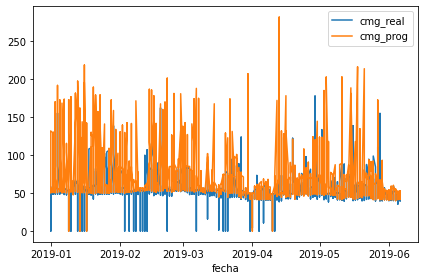

In [46]:
time_plot_costo_barra(cm_df, 'BA40T005SE283T005', None, None)

En términos generales, los costos marginales programados tienden a cubir los costos marginales reales. Sin embargo, en ciertos péridos de tiempo, los costos marginales reales se escapan del rango de valores de los costos marginales programados. 



### Costos marginales reales iguales a 0

Se asume que los costos marginales reales no puden ser 0 todo el tiempo. Dado que esto indicaría que la barra no se encuentra en funcionamiento. Por lo tanto, son suprimidos del dataset

In [49]:
## suprimiendo barras tales que cmg_real = 0
aux = cm_df.groupby("barra")["cmg_real"].sum().to_frame()
aux.columns = ["cmg_real"]
barras_to_drop = aux[aux["cmg_real"]==0].index

cm_df = cm_df[~cm_df["barra"].isin(barras_to_drop)]
cm_df

,barra,fecha,hora,cmg_real,cmg_real_pesos,cmg_prog,desviacion,desviacion_pct,desviacion_cat
0,BA01G004SE001T011,2019-01-01,1,50.41,35.06973,50.116286,0.293714,0.586064,0.0
1,BA01G004SE001T011,2019-01-01,2,50.41,35.06973,50.522836,-0.112836,-0.223336,0.0
2,BA01G004SE001T011,2019-01-01,3,49.40,34.36709,50.119505,-0.719505,-1.435578,0.0
3,BA01G004SE001T011,2019-01-01,4,48.56,33.78271,NaN,NaN,NaN,NaN
4,BA01G004SE001T011,2019-01-01,5,46.51,32.35654,49.854087,-3.344087,-6.707749,0.0
...,...,...,...,...,...,...,...,...,...
4396799,BA99L117SE054L117,2019-06-30,20,47.79,32.49051,46.800602,0.989398,2.114071,0.0
4396800,BA99L117SE054L117,2019-06-30,21,47.79,32.49051,48.607941,-0.817941,-1.682731,0.0
4396801,BA99L117SE054L117,2019-06-30,22,47.79,32.49051,48.537587,-0.747587,-1.540222,0.0
4396802,BA99L117SE054L117,2019-06-30,23,47.79,32.49051,47.783023,0.006977,0.014601,0.0


##### Borramos de la memoria lo que ya no utilizaremos

In [837]:
del aux
del cm_df
del cmr_df
del cmp_df

gc.collect()

(700, 10, 10)

## Parte 4 - Base para modelos

In [2]:
ds = pd.read_csv("base_para_prediccion.csv")
ds["fecha"] = pd.to_datetime(ds["fecha"]).dt.date
ds

,nemotecnico_se,fecha,hora,gen_eolica_total_mwh,gen_geotermica_total_mwh,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,cmg_desv,cmg_desv_pct,n_barras,demanda_mwh,cap_inst_mw
0,SE031G216,2019-01-04,1,NaN,NaN,NaN,NaN,0.000,56.2,55.627852,0.57,1.02,2,1210767,13.20785
1,SE031G216,2019-01-04,2,NaN,NaN,NaN,NaN,0.000,56.2,55.376645,0.82,1.48,2,113232,13.20785
2,SE031G216,2019-01-04,3,NaN,NaN,NaN,NaN,0.000,56.2,59.531891,-3.33,-5.59,2,1089415,13.20785
3,SE031G216,2019-01-04,4,NaN,NaN,NaN,NaN,0.000,56.2,174.378923,-118.18,-67.77,2,1096867,13.20785
4,SE031G216,2019-01-04,5,NaN,NaN,NaN,NaN,0.000,56.2,172.820310,-116.62,-67.48,2,1071851,13.20785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112774,SE170T005,2019-06-30,20,NaN,NaN,NaN,NaN,0.775,44.1,41.362200,2.74,6.62,3,9334786,30.14000
112775,SE170T005,2019-06-30,21,NaN,NaN,NaN,NaN,0.925,44.1,42.217780,1.88,4.45,3,9353773,30.14000
112776,SE170T005,2019-06-30,22,NaN,NaN,NaN,NaN,0.975,44.1,42.197451,1.90,4.50,3,9114529,30.14000
112777,SE170T005,2019-06-30,23,NaN,NaN,NaN,NaN,0.750,44.1,41.473556,2.63,6.34,3,8118728,30.14000


In [3]:
print(f"Cantidad de filas: {ds.shape[0]}")
print(f"Cantidad de variables: {ds.shape[1]}")
print(f"Los datos van del {min(ds['fecha'])} al {max(ds['fecha'])}")
print(f"Hay {len(ds['nemotecnico_se'].unique())} subestaciones en la base de datos")
print(f"Horas de medición: {len(ds['hora'].unique())}")

Cantidad de filas: 112779
Cantidad de variables: 15
Los datos van del 2019-01-01 al 2019-06-30
Hay 29 subestaciones en la base de datos
Horas de medición: 25


### Datatypes

In [4]:
ds.dtypes

nemotecnico_se               object
fecha                        object
hora                          int64
gen_eolica_total_mwh        float64
gen_geotermica_total_mwh    float64
gen_hidraulica_total_mwh    float64
gen_solar_total_mwh         float64
gen_termica_total_mwh       float64
cmg_real                    float64
cmg_prog                    float64
cmg_desv                    float64
cmg_desv_pct                float64
n_barras                      int64
demanda_mwh                   int64
cap_inst_mw                 float64
dtype: object

### Estadísticas descriptivas de las variables numéricas

In [63]:
ds.describe().drop("count")

,hora,gen_eolica_total_mwh,gen_geotermica_total_mwh,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,cmg_desv,cmg_desv_pct,n_barras,demanda_mwh,cap_inst_mw
mean,12.502993,NaN,NaN,38.120053,3.764987,40.583146,61.170058,62.215400,-1.045338,inf,2.331844,6.357056e+07,128.719565
std,6.924090,NaN,NaN,69.838109,12.904388,101.083396,25.414147,25.307759,24.711575,NaN,1.304096,3.948683e+08,167.948649
min,1.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,-1.713131,-562.470000,-3403.97,1.000000,-9.821095e+09,2.989800
25%,7.000000,NaN,NaN,0.849787,0.000000,0.000000,49.130000,49.906745,-3.790000,-7.07,1.000000,7.464800e+05,18.420000
50%,13.000000,NaN,NaN,9.600000,0.000000,0.000000,54.610000,55.420601,-0.310000,-0.58,2.000000,4.507282e+06,51.850000
75%,19.000000,NaN,NaN,40.000000,1.571022,15.960000,63.500000,64.701951,1.670000,2.92,3.000000,1.332345e+07,184.685500
max,25.000000,NaN,NaN,472.000000,86.050000,570.600800,240.360000,610.600000,175.020000,inf,6.000000,1.004240e+10,597.782800


### Estadísticas descriptivas de las variables categóricas

In [64]:
ds.describe(include='object').drop("count").T

,unique,top,freq
nemotecnico_se,29,SE004T002,4345
fecha,181,2019-04-06,675


### Valores nulos

In [65]:
missing_values_table(ds)

Hay 15 columnas.
Hay 5 columns with missing values


,Missing Values,% of Total Values
gen_eolica_total_mwh,112779,100.0
gen_geotermica_total_mwh,112779,100.0
gen_hidraulica_total_mwh,78595,69.7
gen_solar_total_mwh,70961,62.9
gen_termica_total_mwh,50916,45.1


No hay datos sobre la generación eólica total, ni de la generación geotérmica total.

### Valores duplicados

In [66]:
print(f"Hay {ds.shape[0] - ds.drop_duplicates().shape[0]} filas duplicadas")

Hay 0 filas duplicadas


### Nuevas variables para representar la variabilidad temporal

In [5]:
%%time
# año
ds["ano"] = ds["fecha"].apply(lambda row: row.year)

# mes
ds["mes"] = ds["fecha"].apply(lambda row: row.month)

# week of year
ds["semana_ano"] = ds["fecha"].apply(lambda row: row.isocalendar()[1])

# día del calendario
ds["dia_calendario"] = ds["fecha"].apply(lambda row: int((row - datetime.date(row.year, 1, 1)).days) + 1) 

# día de la semana
ds["dia_semana"] = ds["fecha"].apply(lambda row: row.weekday())

# fin de semana
ds["findesemana"] = ds["dia_semana"].apply(lambda row: 1 if row in [5,6] else 0)

horas_ano = pd.DataFrame({"dia_calendario": sorted(len(ds["hora"].unique())* [d for d in ds["dia_calendario"].unique()]), 
                           "hora_dia": len(ds["dia_calendario"].unique()) * [h for h in sorted(ds["hora"].unique())],
                          "hora_ano": range(1,len(sorted(len(ds["hora"].unique())* [d for d in ds["dia_calendario"].unique()]))+1)})

# hora del año
ds["hora_ano"] = ds.apply(lambda row: get_hora_ano(horas_ano, row["dia_calendario"], row["hora"]) , axis=1)
ds = ds.sort_values("hora_ano")

# total mwh
ds["en_total_mwh"] = np.sum(ds[[c for c in ds.columns if "total" in c]], axis=1)

# variable categórica: 1 si la desvición de costos marginales porcentual es superior al 15 %
ds["cmg_cat"] = np.where(abs(ds["cmg_desv_pct"]) <= 15, 0, 1)

Wall time: 1min 9s


### Evolución diaria de la generación solar y térmica total

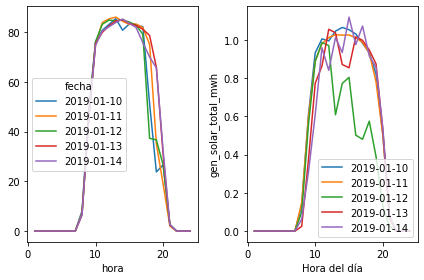

In [49]:
fig, axs = plt.subplots(1,2)
fechas = [f"2019-01-{i}" for i in range(10, 15)]


evolucion_diaria(ds, "SE005T002", "gen_solar_total_mwh", fechas, ax=axs[0])
evolucion_diaria(ds, "SE127T005", "gen_solar_total_mwh", fechas, ax=axs[1])

plt.legend(loc = 'lower right')
plt.tight_layout()

La generación solar dependende fuertemente de la subestación. Podemos ver que la subestación SE005T002 tiene una generación térmica ordénes de magnitude más grande que la SE127T005. Esto puede ser debido a las diferencias en infrastructura y locación geográfica de las subestaciones.

La subestación SE005T002 tiene un perfil de generación solar diaria similar para los 5 días gráficados. Por su lado, la subestación SE127T005 posee mayor variablidad entre los días graficados.

Ambos gráficos muestran un ciclo diario de generación solar. No hay generación durante la noche. Luego, entre la mañana y la tarde la generación solar va en aumento, hasta llegar a su peak cercano a las 3 de la tarde. Luego, comienza el descenso hasta zero. Esto puede ser debido al ciclo solar en el día. 

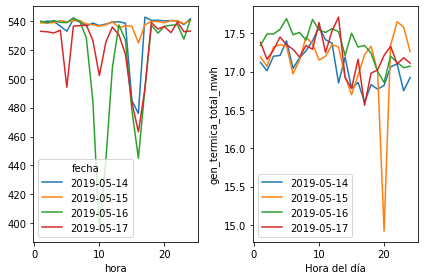

In [54]:
fig, axs = plt.subplots(1,2)
fechas = [f"2019-05-{i}" for i in range(14, 18)]


evolucion_diaria(ds, "SE020G213", "gen_termica_total_mwh", fechas, ax=axs[0])
evolucion_diaria(ds,"SE106G216", "gen_termica_total_mwh", fechas, ax=axs[1])

plt.tight_layout()

La generación térmica dependende fuertemente de la subestación. Podemos ver que la subestación SE020G213 tiene una generación térmica ordénes de magnitude más grande que la SE106G216.

Dependiendo del día, la generación térmica de las subestaciones puede variar considerablemente. Por ejemplo la subestación SE020G213 tiene un descenso inusual de la generación de energía a la hora 10 del día 16 de mayo. Mismo caso para la subestación  SE106G216 el día 15 de mayo a las 20 horas. Una explicación podría ser que las diminuciones inusuales pueden ser producto de eventos puntuales en las subestaciones. 

## Partes 5, 6, y 7: Modelos de predicción

### Strategía

#### Modelación de las series de tiempo
+ Cada barra corresponde a una serie de tiempo. Sin embargo, podemos consideraras como una sola serie de tiempo, y considerar el nombre de la barra como una variable más. Si hacemos esto, multiplicamos la cantidad de datos que tenemos para entrenar un modelo de clasificación.
+ Las series de tiempo son indexadas por la hora en el año que se produce. La primera hora del año parte a la hora 1 del primer día que se tiene registros, y así continua hasta la última hora del último día del que se tiene registro.

#### Feature engineering:
+ Ordinal Encoder para el nombre de la barra: se enumeran los nombres de las barras de 0 en adelante
+ lags: lags de 1 a 5 horas de diferecía
+ stats moviles: 
    + calculo del promedio móvil simple
    + el promedio móvil acumulado
    + promedio exponencial ponderado
    + varianza móvil simple
    + varianza móvil acumulada
    + la varianza exponencial ponderada. 
+ Estos promedios son realizados con los mismos lags de arriba

#### Target
+ target: cmg_cat de 1 (modelo 1), y 12 (modelos 2 y 3) días en el futuro. 

#### Feature selection
+ Feature selection: Se suprimen todas las variables por las que el 100 % de los valores son nulos

### Validación

+ Basados en la columna 'hora_ano' podemos dividir temporalmente los conjuntos de entrenamiento, validación, y test. Así nos aseguramos de no sufrir 'data leakage'. 
+ el último 10 % (temoralmente) de los datos son utilizados como conjunto de test. El 90 % restante es utilizado para crear 5 folders donde los conjunto de entrenamiento y validación se dividen temporalmente. El conjunto de entrenamiento va desde la primera hora del primer día hasta un hora arbitrarea de un día arbitrareo, luego el conjunto de validación le sigue de en tiempo.

+ La performance del modelo es medida en términos de:
    + área roc: dado que hay un desbalance de clases (hay muchos menos desvíos superiores que inferiores al 15 %)
    + f1: dado que no comprendo todavía cúal clase es más importante, el f1 me da una idea del promedio entre la precisión y el recall.
    
### Modelo: XGBOOST
+ XGBOOST es un modelo no linear ensemble, que permite boostear las predicciones de los árboles de decisión. Famoso por ganar competencias kaggle.
+ XGBOOST es capaz de trabajar con valores nulos. Dada la naturaleza de nuestros datos. Esto simplifica el workflow
+ XGBOOST permite calcular la importancia de las variables e incluso realizar una selección de variables.
+ Los paramétros de max_depth, n_estimators, y reg_alpha permiten evitar el overfitting
+ No es necesario realizar normalización de las variables. Esto simplifica el workflow

### Optimización de hiper-parámetros
+ GridSearchCV: Se realiza una búsqueda por grilla los parámetros mencionados arriba para evitar over fitting. Esto se realiza en cojunto a la validación.
    

## Parte 5 - Modelo 1 - predecir la hora siguiente

Creating features from ['cmg_desv', 'demanda_mwh', 'cap_inst_mw', 'en_total_mwh'].
Using ['lag', 'sma', 'cma', 'ewm', 'smvar', 'cmvar', 'ewvar']



Hay 159 columnas.
Hay 112 columnas con valores nulos
Dropping 8 features because the 100 % of the column is NaN
Creating 5 validation folders



--------- Main results trainset: --------- 
f1 train: 1.0
roc auc train: 1.0


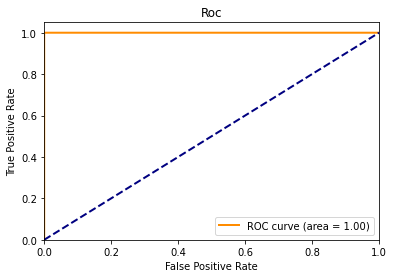

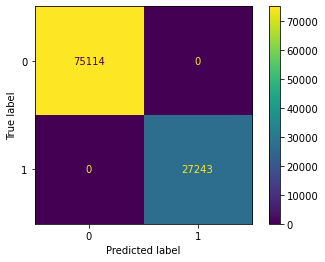

--------- Main results testset: --------- 
f1 test: 0.235
roc auc test: 0.851


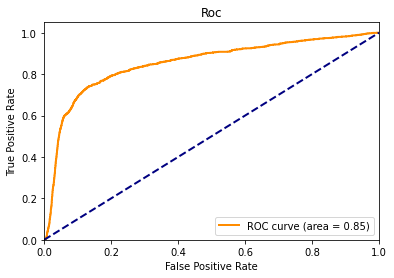

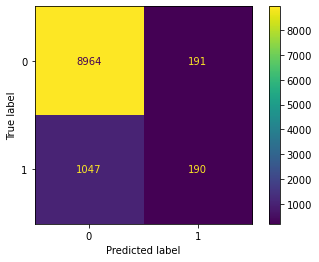

best parameters: {'classifier__max_depth': 100, 'classifier__n_estimators': 100, 'classifier__random_state': 123}


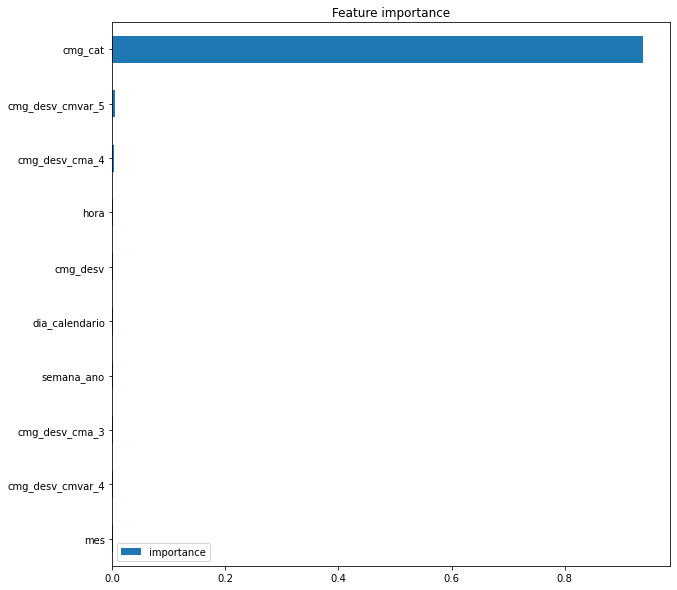

,importance
cmg_cat,0.938990
cmg_desv_cmvar_5,0.004961
cmg_desv_cma_4,0.003121
hora,0.001762
cmg_desv,0.001584
dia_calendario,0.001525
semana_ano,0.001508
cmg_desv_cma_3,0.001427
cmg_desv_cmvar_4,0.001407
mes,0.001299


Hay 43 variables que no influyen
Wall time: 28min 52s


In [39]:
%%time

lag = -1

res_xgb_1 = run_xgb(ds, lag=lag, save_model_as="modelo_1.pkl")

El modelo sufre de overfiting. ÉL funciona perfecto en el conjunto de entrenamiento, pero pierde performance en el conjunto de test.

La variable más importnate es si hubo o no una desviación superior al 15 % la hora antes. 

## Parte 6 - Modelo 2 : predecir 12 horas siguientes

Creating features from ['cmg_desv', 'demanda_mwh', 'cap_inst_mw', 'en_total_mwh'].
Using ['lag', 'sma', 'cma', 'ewm', 'smvar', 'cmvar', 'ewvar']



Hay 159 columnas.
Hay 112 columnas con valores nulos
Dropping 8 features because the 100 % of the column is NaN
Creating 5 validation folders



--------- Main results trainset: --------- 
f1 train: 0.997
roc auc train: 1.0


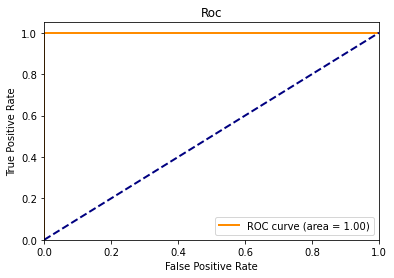

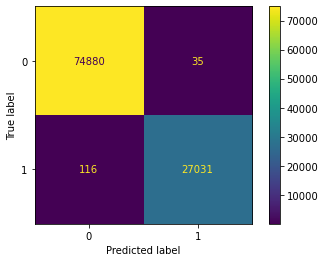

--------- Main results testset: --------- 
f1 test: 0.002
roc auc test: 0.582


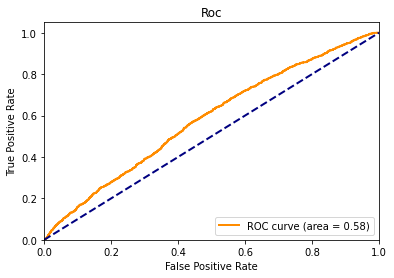

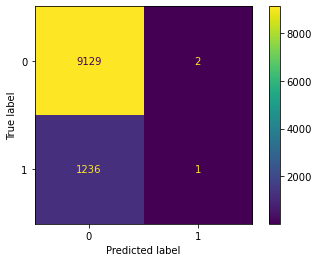

best parameters: {'classifier__max_depth': 10, 'classifier__n_estimators': 100, 'classifier__random_state': 123}


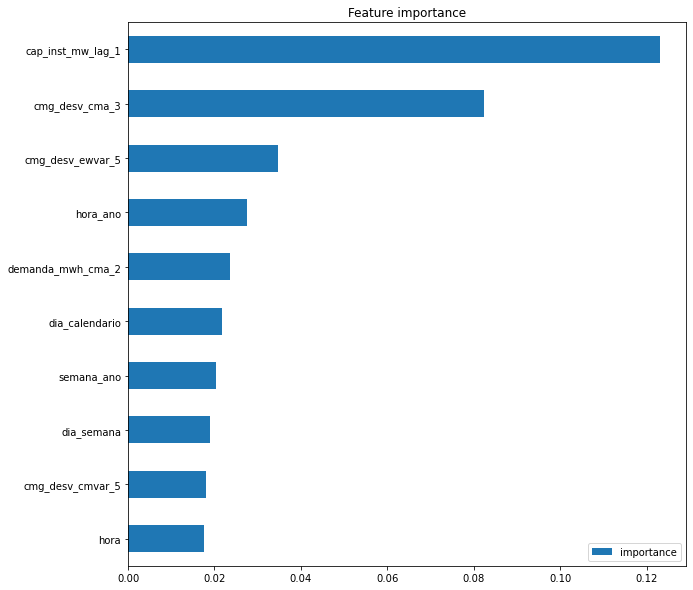

,importance
cap_inst_mw_lag_1,0.122995
cmg_desv_cma_3,0.082461
cmg_desv_ewvar_5,0.034754
hora_ano,0.027438
demanda_mwh_cma_2,0.023476
dia_calendario,0.021670
semana_ano,0.020251
dia_semana,0.018967
cmg_desv_cmvar_5,0.018026
hora,0.017562


Hay 38 variables que no influyen
Wall time: 26min 51s


In [41]:
%%time

lag = -12

res_xgb_2 = run_xgb(ds, lag=lag, save_model_as="modelo_2.pkl")

Nuevamente el modelo funciona mucho mejor en el conjunto de entrenamiento que en el de test. Sin embargo, en este el modelo funciona mucho peor en el conjunto de test y presenta solo una leve mejora con respecto a predecir aleatoriamente.

En este caso, el desbalance de clase hace tender al modelo a elegir la clase 0 (predecir que no habrá desviación). 

La variable de mayor importancia en este caso fue la capacidad de generación máxima instalada por subestación de la hora anterior.

## Parte 7 - Modelo 3 : predecir 12 horas siguientes con datos del clima

Creating features from ['cmg_desv', 'demanda_mwh', 'cap_inst_mw', 'en_total_mwh'].
Using ['lag', 'sma', 'cma', 'ewm', 'smvar', 'cmvar', 'ewvar']



Hay 177 columnas.
Hay 112 columnas con valores nulos
Dropping 8 features because the 100 % of the column is NaN
Creating 5 validation folders



--------- Main results trainset: --------- 
f1 train: 0.998
roc auc train: 1.0


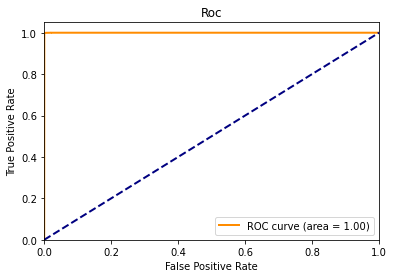

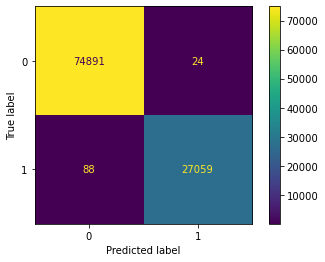

--------- Main results testset: --------- 
f1 test: 0.002
roc auc test: 0.609


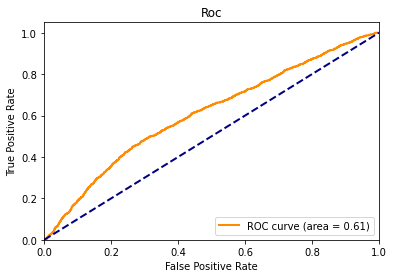

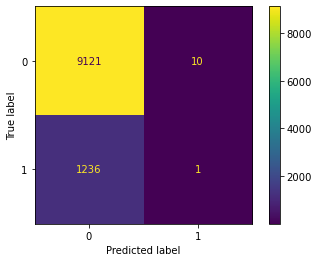

best parameters: {'classifier__max_depth': 10, 'classifier__n_estimators': 100, 'classifier__random_state': 123}


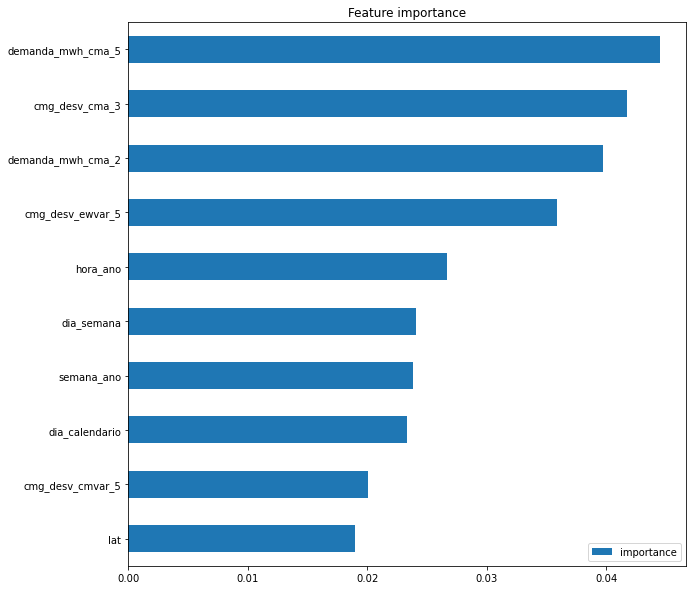

,importance
demanda_mwh_cma_5,0.044469
cmg_desv_cma_3,0.041765
demanda_mwh_cma_2,0.039771
cmg_desv_ewvar_5,0.035902
hora_ano,0.026722
dia_semana,0.024091
semana_ano,0.023856
dia_calendario,0.023356
cmg_desv_cmvar_5,0.020107
lat,0.018968


Hay 39 variables que no influyen
Wall time: 27min 55s


In [42]:
%%time

lag = -12

clima_df = pd.read_csv("datos_clima.csv")
clima_df["fecha"] = pd.to_datetime(clima_df["fecha"]).dt.date
new_df = pd.merge(ds, clima_df, how='left', left_on=['fecha','nemotecnico_se'], right_on=['fecha','subestacion'])
new_df = new_df.drop("subestacion", axis=1)

res_xgb_3 = run_xgb(new_df, lag=lag, save_model_as="modelo_3.pkl")

Al igual que los otros modelos, el modelo presenta overfitting. Sin embargo, la adicción de datos climáticos ha mejorado la performance. 

La variable más importante en este caso fue el promedio móvil acumulado de los últimos 5 días de los retiros de energía efectuados por compañías coordinadas bajo el sistema eléctrico

## Parte 8 - Reflexión

+ Poder anticiparse a la desviación entre el costo marginal programado y el real permite evaluar el método con el que se calculan los costos marginales programados. Además, permite tomar medidas con anticipación en caso de una desviación considerable (en ente caso de un 15 % o más).

+ El modelo permite además ver la influencia de las variables utilizadas. Así las personas encargadas de minimizar los costos marginales pueden enfocarse en las variables más relevantes. ´Pueden enfocar los esfuerzos en minimizar los efectos de dichas variables y así minimizar la probabilidad de una desviación.
